# WRDS Data Collection

In [4]:
import pandas as pd
import numpy as np
import wrds
import pandas_market_calendars as mcal
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt

In [87]:
conn = wrds.Connection(wrds_username='kaihvc')

Loading library list...
Done


In [40]:
q = "SELECT * FROM crsp.dsf WHERE date>='1950-1-1' AND date<='1960-1-1' AND prc*shrout>=10000000"
df_early = conn.raw_sql(q)
df_early.head()

,cusip,permno,permco,issuno,hexcd,hsiccd,date,bidlo,askhi,prc,vol,ret,bid,ask,shrout,cfacpr,cfacshr,openprc,numtrd,retx
0,37044210,12079.0,20799.0,0.0,1.0,3711.0,1955-06-23,108.625,110.125,109.750,22700.0,0.010357,None,None,91869.0,8.028598,6.0,109.500,None,0.010357
1,37044210,12079.0,20799.0,0.0,1.0,3711.0,1955-06-24,108.875,109.875,109.625,14100.0,-0.001139,None,None,91869.0,8.028598,6.0,109.375,None,-0.001139
2,37044210,12079.0,20799.0,0.0,1.0,3711.0,1955-06-27,109.000,109.625,109.000,10600.0,-0.005701,None,None,91869.0,8.028598,6.0,109.625,None,-0.005701
3,26353410,11703.0,20606.0,0.0,1.0,2879.0,1955-06-28,217.500,225.000,223.000,3300.0,0.020595,None,None,45488.0,25.767878,18.0,217.750,None,0.020595
4,26353410,11703.0,20606.0,0.0,1.0,2879.0,1955-06-29,221.000,228.500,226.500,3900.0,0.015695,None,None,45488.0,25.767878,18.0,222.000,None,0.015695


In [38]:
np.unique(df_early['cusip'].values)

array(['00195750', '26353410', '30231G10', '37044210'], dtype=object)

In [90]:
def get_days(start_dt, end_dt):
    nyse = mcal.get_calendar('NYSE')
    return [day.date() for day in nyse.valid_days(start_date=str(start_dt), 
                                                end_date=str(end_dt))]

In [91]:
def get_weeks(start_dt, end_dt):
#     weekday_dict = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 
#                     'Friday': 4, 'Saturday': 5, 'Sunday': 6}
#     rollover = weekday_dict[weekday]
    weeks = []

    # get trading days and divide into weeks, rolling over on the given rollover day
    current_week = []
    days = get_days(start_dt, end_dt)
    for i, day in enumerate(days):
        # append to current week
        current_week.append(day)

        #end of the week check
        if i+1<len(days):
            next_day = days[i+1]
            if next_day.weekday() < day.weekday(): #if the next day's weekday comes before the current, then the next_day is in a new week
                weeks.append(current_week)
                current_week = []
            elif (next_day-day).days > 4: #if the condition above didnt pass, check that >4 days didnt pass as well
                weeks.append(current_week)
                current_week = []

    # append final week, even if it wasn't a full week period
    if current_week: weeks.append(current_week)

    return weeks

In [92]:
def get_periods(weeks):
    periods = []
    start_date = weeks[0][0]
    end_date = None
    for i in range(len(weeks)-1):
        start = weeks[i][0] #this monday
        end = weeks[i][-1]  #this friday

        next_start = weeks[i+1][0] #next monday
        next_end = weeks[i+1][-1]  #next friday

        #if the current friday is in december, and the next weeks friday is in january, this is the end of one period
        #the very next week will be the very start of the period\
        if end.month == 12 and next_end.month == 1:
            end_date = end
            periods.append([start_date,end_date])
            start_date = next_start
        #if the last day is in june, and the next weeks last day is in july, this is the end of one period
        #the very next week will be the very start of the period
        if end.month == 6 and next_end.month == 7:
            end_date = end
            periods.append([start_date,end_date])
            start_date = next_start
    periods.append([start_date, weeks[i+1][-1]])
    for i in periods:
        i[1] += timedelta(days=3)
    return periods

In [97]:
# combine daily returns into weekly ones
# start_dt and end_dt are datetime.date objects
# writes weekly data to file
def get_weekly_rets(start_dt, end_dt):
    
    # parameters
    min_valid_weeks = 20 # minimum # of valid weeks to calculate std
    min_market_cap = 10000 # minimum market cap a stock must have to be counted
    
    # get cusip/ticker and week info; set up name/week/period references
    conn = wrds.Connection(wrds_username='kaihvc')
    name_fields = ['cusip']
    names = conn.get_table(library='crsp', table='stocknames', columns=name_fields)
    name_dict = dict()
    weeks = get_weeks(start_dt, end_dt)
    wk_starts = [week[0] for week in weeks]
    # REMIND: per[1] is the next Monday, so we need a ' - timedelta(days=1)' 
    #   either here or in get_periods)
    periods = get_periods(weeks)
    
    # file to store weekly returns (reset on every run)
#     with open('data/temp_wkly_rets.csv', 'w') as file:
#         file.write('cusip,date,ret')
    with open('data/temp_deviations.csv', 'w') as file:
        file.write('cusip,date,std')
    
    # data collection/processing
    print('Iterating through tickers...')
    for cusip in names.iloc[::-8600]['cusip']:
        if cusip not in name_dict:
            
            # get data for cusip & filter by market cap
            query = f"SELECT date, ret FROM crsp.dsf WHERE cusip='{cusip}' AND date>='{str(start_dt)}' AND date<='{str(end_dt)}' AND prc*shrout>={min_market_cap}"
            daily_data = conn.raw_sql(query)
            if daily_data.empty:
                name_dict[cusip] = ''
                continue
            
            # create weekly ret & std dataframes
            weekly_returns = pd.DataFrame(index=pd.MultiIndex.from_product([[cusip], wk_starts]), 
                                                              columns=['return'])
            devs = pd.DataFrame(index=[cusip], columns=['P' + str(i) for i in range(len(periods))])
#             devs = pd.DataFrame(index=pd.MultiIndex.from_product([[cusip], 
#                                                                  [per[0] for per in periods]]),
#                                                                  columns=['std'])
            
            # separate into weeks
            for week in weeks:
                
                # if daily data exists for this stock for this week, calculate returns
                day_indices = daily_data['date'].isin(week)
                if np.any(day_indices):
                    
                    # overall weekly return calculation
                    daily_rets = daily_data['ret'].loc[day_indices]
                    weekly_ret = np.product([1 + ret for ret in daily_rets]) - 1
                    weekly_returns.loc[(cusip, week[0]), 'return'] = weekly_ret
                    
            # calculate standard deviations of ~26 week periods
            for i, per in enumerate(periods):
            
                period_returns = weekly_returns.loc[cusip][per[0]:per[1] - timedelta(days=1)].dropna().values
                std = np.std(period_returns) if len(period_returns) >= min_valid_weeks else np.nan
                
                devs.loc[cusip]['P' + str(i)] = std
#                 devs.loc[(cusip, per[0]), 'std'] = std # index by monday
            
            # if weekly return data exists, append to file
            if not weekly_returns['return'].dropna().empty:
#                 with open('data/temp_wkly_rets.csv', 'a') as file:
#                     weekly_returns.to_csv(file, header=False)
                with open('data/temp_deviations.csv', 'a') as file:
                    devs.to_csv(file, header=False)
            
            # flag cusip as completed
            name_dict[cusip] = ''
            
    print('Done')

In [98]:
get_weekly_rets(date(1950, 1, 1), date(2021, 1, 1))

Loading library list...
Done
Iterating through tickers...
Done


Notes: need 20/26 weeks to be valid  
Figure out holidays within `get_weeks()`, then just throw out NaNs in the data  
Outstanding shares are reported in thousands, so we should adjust our market cap calculation

## Parallelizable implementation

In [28]:
# combine daily returns into weekly ones
# start_dt and end_dt are datetime.date objects
# nsplits is number of segments to portion the cusip name list into
# worker id indicates which segments the function should work with
def get_weekly_rets_parallel(start_dt, end_dt, conn, names, name_dict, weeks, 
                             periods, nsplits=7, worker_id=0):
    
    # parameters
    min_valid_weeks = 20 # minimum # of valid weeks to calculate std
    min_market_cap = 10000000 # minimum market cap a stock must have to be counted
    
    # get cusip/ticker and week info; set up name/week/period references
#     conn = wrds.Connection(wrds_username='kaihvc')
#     name_fields = ['cusip']
#     names = conn.get_table(library='crsp', table='stocknames', columns=name_fields)
#     name_dict = dict()
#     weeks = get_weeks(start_dt, end_dt)
    wk_starts = [week[0] for week in weeks]
#     # REMIND: per[1] is the next Monday, so we need a ' - timedelta(days=1)' 
#     #   either here or in get_periods)
#     periods = get_periods(weeks)
    
    # parallelizability
    interval = int(len(names) / splits)
    slice_start = worker_id * interval
    slice_end = min(slice_start + interval, len(names))
    
    # file to store weekly returns (reset on every run)
    with open(f'wrds_results/temp_wkly_rets{worker_id}.csv', 'w') as file:
        file.write('cusip,date,ret\n')
    with open(f'wrds_results/temp_deviations{worker_id}.csv', 'w') as file:
        file.write('cusip,date,std\n')
    
    # data collection/processing
    for cusip in names.iloc[slice_start:slice_end]['cusip']:
        if cusip not in name_dict:
            
            # get data for cusip & filter by market cap
            query = f"SELECT date, ret FROM crsp.dsf WHERE cusip='{cusip}' AND date>='{str(start_dt)}' AND date<='{str(end_dt)}' AND prc*shrout>={min_market_cap}"
            daily_data = conn.raw_sql(query)
            
            # create weekly ret & std dataframes
            weekly_returns = pd.DataFrame(index=pd.MultiIndex.from_product([[cusip], wk_starts]), 
                                                              columns=['return'])
            devs = pd.DataFrame(index=[cusip], columns=['P' + str(i) for i in range(len(periods))])
#             devs = pd.DataFrame(index=pd.MultiIndex.from_product([[cusip], 
#                                                                  [per[0] for per in periods]]),
#                                                                  columns=['std'])
            
            # separate into weeks
            for week in weeks:
                
                # if daily data exists for this stock for this week, calculate returns
                day_indices = daily_data['date'].isin(week)
                if np.any(day_indices):
                    
                    # overall weekly return calculation
                    daily_rets = daily_data['ret'].loc[day_indices]
                    weekly_ret = np.product([1 + ret for ret in daily_rets]) - 1
                    weekly_returns.loc[(cusip, week[0]), 'return'] = weekly_ret
                    
            # calculate standard deviations of ~26 week periods
            for i, per in enumerate(periods):
            
                period_returns = weekly_returns.loc[cusip][per[0]:per[1] - timedelta(days=1)].dropna().values
                std = np.std(period_returns) if len(period_returns) >= min_valid_weeks else np.nan
                
                devs.loc[cusip]['P' + str(i)] = std
#                 devs.loc[(cusip, per[0]), 'std'] = std # index by monday
            
            # if weekly return data exists, append to file
            if not weekly_returns['return'].dropna().empty:
                with open(f'wrds_results/temp_wkly_rets{worker_id}.csv', 'a') as file:
                    weekly_returns.to_csv(file, header=False)
                with open(f'wrds_results/temp_deviations{worker_id}.csv', 'a') as file:
                    devs.to_csv(file, header=False)
            
            # flag cusip as completed
            name_dict[cusip] = ''

In [29]:
splits = 100
start_dt = date(1950, 1, 1)
end_dt = date(2021, 11, 11)
for i in range(1):
    # setup
    conn = wrds.Connection(wrds_username='kaihvc')
    name_fields = ['cusip']
    names = conn.get_table(library='crsp', table='stocknames', columns=name_fields)
    name_dict = dict()
    weeks = get_weeks(start_dt, end_dt)
    periods = get_periods(weeks)
    
    print(f'Gathering data for split {i}...')
    get_weekly_rets_parallel(start_dt, end_dt, conn, names, name_dict, weeks, 
                             periods, nsplits=splits, worker_id=i)
    print(f'Split {i} complete')

Loading library list...
Done
Gathering data for split 0...
Split 0 complete


In [24]:
for i in range(1, splits):
    conn = wrds.Connection(wrds_username='kaihvc')
    print(f'Gathering data for split {i}...')
    get_weekly_rets_parallel(start_dt, end_dt, conn, nsplits=splits, worker_id=i)
    print(f'Split {i} complete')

Loading library list...
Done
Gathering data for split 1...


KeyboardInterrupt: 

## Results

In [3]:
conn = wrds.Connection(wrds_username='kaihvc')

Loading library list...
Done


In [5]:
df_devs = pd.read_csv('wrds_results/temp_deviations (1).csv',index_col=0)
# df_names = conn.raw_sql('SELECT cusip, ticker FROM crsp.stocknames')

# df_names.head()
# tickers = df_names.loc[df_names['cusip'].isin(df.index)]
# name_dict = 
# for i, row in tickers.iterrows():
#     print(row)
# print(len(df.index))
# weeks = get_weeks(date(1950, 1, 1), date(2021, 1, 1))
# periods = get_periods(weeks)
# print(len(periods))
# df.columns = [per[0] for per in periods]

In [15]:
df_devs[df_devs.index == '39031810']

,01/03/1950 - 07/03/1950,07/03/1950 - 01/02/1951,01/02/1951 - 07/02/1951,07/02/1951 - 01/01/1952,12/31/1951 - 06/30/1952,06/30/1952 - 12/29/1952,12/29/1952 - 06/29/1953,06/29/1953 - 01/03/1954,01/04/1954 - 06/28/1954,06/28/1954 - 01/03/1955,...,01/04/2016 - 06/27/2016,06/27/2016 - 01/02/2017,01/03/2017 - 07/03/2017,07/03/2017 - 01/01/2018,01/02/2018 - 07/02/2018,07/02/2018 - 12/31/2018,12/31/2018 - 07/01/2019,07/01/2019 - 12/30/2019,12/30/2019 - 06/29/2020,06/29/2020 - 01/03/2021


In [13]:
df_devs.head()

,01/03/1950 - 07/03/1950,07/03/1950 - 01/02/1951,01/02/1951 - 07/02/1951,07/02/1951 - 01/01/1952,12/31/1951 - 06/30/1952,06/30/1952 - 12/29/1952,12/29/1952 - 06/29/1953,06/29/1953 - 01/03/1954,01/04/1954 - 06/28/1954,06/28/1954 - 01/03/1955,...,01/04/2016 - 06/27/2016,06/27/2016 - 01/02/2017,01/03/2017 - 07/03/2017,07/03/2017 - 01/01/2018,01/02/2018 - 07/02/2018,07/02/2018 - 12/31/2018,12/31/2018 - 07/01/2019,07/01/2019 - 12/30/2019,12/30/2019 - 06/29/2020,06/29/2020 - 01/03/2021
36720410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0285,0.1213,0.0052,NaN,NaN,NaN,NaN,NaN,NaN,NaN
05978R10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39031810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00080010,0.0606,0.049,0.037,0.0363,0.0266,0.0268,0.0364,0.0262,0.0281,0.0329,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36547310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


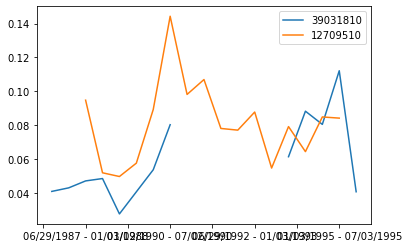

In [4]:
plot, ax = plt.subplots()
# ax.set_xlabel([per[0] for per in periods])
df_devs.iloc[2].plot(ax=ax)
df_devs.iloc[6].plot(ax=ax)
ax.legend()
plt.show()

## Ranking
Now that we have the data, we have 3 tasks:
1. For each period, rank each stock in terms of lowest to highest volatility
2. For each period, divide the stocks into deciles in terms of volatility
3. Calculate a correlation matrix of each stock's volatility  

In addition to this, we may do some modeling of movement between deciles or rankings using Markov models.  

Note: `np.argsort()` sorts in _ascending_ order, meaning rank 1 will have the _highest_ volatility; to reverse this, append `[::-1]` to the end.  

Further note: NaN values are maintained through the ranking/decilation process, so if a stock dips to rank 1 suddenly, that's _significant_; it doesn't just mean there was suddenly not data.

In [6]:
df_rankings = pd.DataFrame(columns=df_devs.columns)
df_deciles = pd.DataFrame(columns=df_devs.columns)
replace_dict = {-1: np.nan, -1.0: np.nan}
for col in df_devs.columns:
    argsorted = np.argsort(df_devs[col]).replace(replace_dict)[::-1]
    df_rankings[col] = argsorted
    df_deciles[col] = argsorted // (np.max(argsorted) / 10) + 1

In [7]:
with open('wrds_results/rankings.csv', 'w') as file:
    df_rankings.to_csv(file)
with open('wrds_results/deciles.csv', 'w') as file:
    df_deciles.to_csv(file)

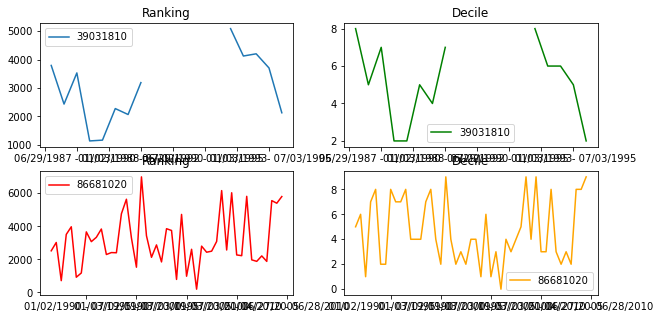

In [6]:
plots, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 5))

df_rankings.loc['39031810'].plot(ax=axes[0][0])
df_deciles.loc['39031810'].plot(ax=axes[0][1], color='green')

df_rankings.loc['86681020'].plot(ax=axes[1][0], color='red')
df_deciles.loc['86681020'].plot(ax=axes[1][1], color='orange')

axes[0][0].set_title('Ranking')
axes[0][1].set_title('Decile')
axes[1][0].set_title('Ranking')
axes[1][1].set_title('Decile')

for row in axes:
    for col in row:
        col.legend()
plt.show()

In [4]:
start_time = datetime.now()
corr_mat = df_devs.T.corr()
end_time = datetime.now()
print(f'Correlation matrix complete in {str(end_time - start_time)}')

Correlation matrix complete in 0:02:08.696753


In [17]:
period_corr = df_devs.corr()

In [38]:
new_mat = []
for i, (_, row) in enumerate(period_corr[:20].iterrows()):
    row_list = row.to_list()
    new_mat.append(row_list[i:])
    i += 1
    
min_len = min([len(elt) for elt in new_mat])
new_mat_array = np.array([elt[:min_len] for elt in new_mat])

In [1]:
new_mat_corrs = []
iterator = iter(new_mat_array)
for col in iterator:
    new_mat_corrs.append(np.corrcoef(col, next(iterator))[0][1])
    
len(new_mat_corrs[0])

NameError: name 'new_mat_array' is not defined

In [2]:
fig, ax = plt.subplots()
ax.plot(new_mat_corrs)
plt.show()

NameError: name 'plt' is not defined

In [24]:
period_corr.index[0]

'01/03/1950 - 07/03/1950'

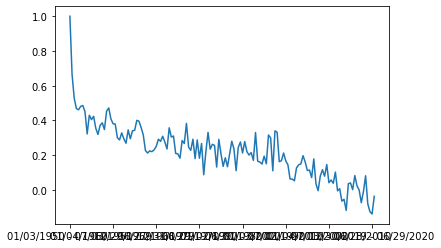

In [25]:
period_corr.iloc[0].plot()
plt.show()

In [5]:
corr_mat.to_csv('wrds_results/correlation.csv')

A note on correlation & ranking: NaN values are always ignored, so:
- Rankings for a given period only take into account the stocks with data for that entire period
- Correlation between two stocks only accounts for the period for which both of those stocks have data

In [ ]:
sorted_correlations = np.sort(corr_mat[corr_mat < 1])

In [ ]:
print(corr_mat[corr_mat.iloc[13].isnull()]) 

Next steps:  
Rank by how many deviations above/below the mean a stock is